In [1]:
import sys
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import random


# Prepare Environment

In [2]:
# Load pallets library

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))  # uncomment to run nb from 'pallets/nb'
# sys.path.append(os.path.abspath(os.getcwd()))                    # uncomment to run from project root

from pallets import images as I, datasets as DS, models as M, logging as L


In [3]:
# To GPU, or not to GPU
device = M.get_device(require_gpu=True)

# Logging
L.init_logger(notebook=True)


<Logger pallets (INFO)>

# The Colors and The Shapes

The images are 24x24 with 4 color channels for RGB and transparency. We simplify access to both with functions found in the `pallets.images` module, which we use as `I`.

In [4]:
# Load image for 0th punk
image = I.get_punk_tensor(0)

# Get list of colors found in image
colors = I.one_image_colors(image)

print(f"image shape: {image.shape}\n")
print(f"total colors: {len(colors)}\n")
print(f"image colors:\n{colors}")


image shape: torch.Size([4, 24, 24])

total colors: 7

image colors:
tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.3137, 0.4863, 0.2000, 1.0000],
        [0.3647, 0.5451, 0.2627, 1.0000],
        [0.3725, 0.1137, 0.0353, 1.0000],
        [0.6824, 0.5451, 0.3804, 1.0000],
        [1.0000, 0.9647, 0.5569, 1.0000]])


In [5]:
# Get list of unique colors for all punk images

all_colors = I.get_punk_colors()

print(f"colors found: {len(all_colors)}")


colors found: 222


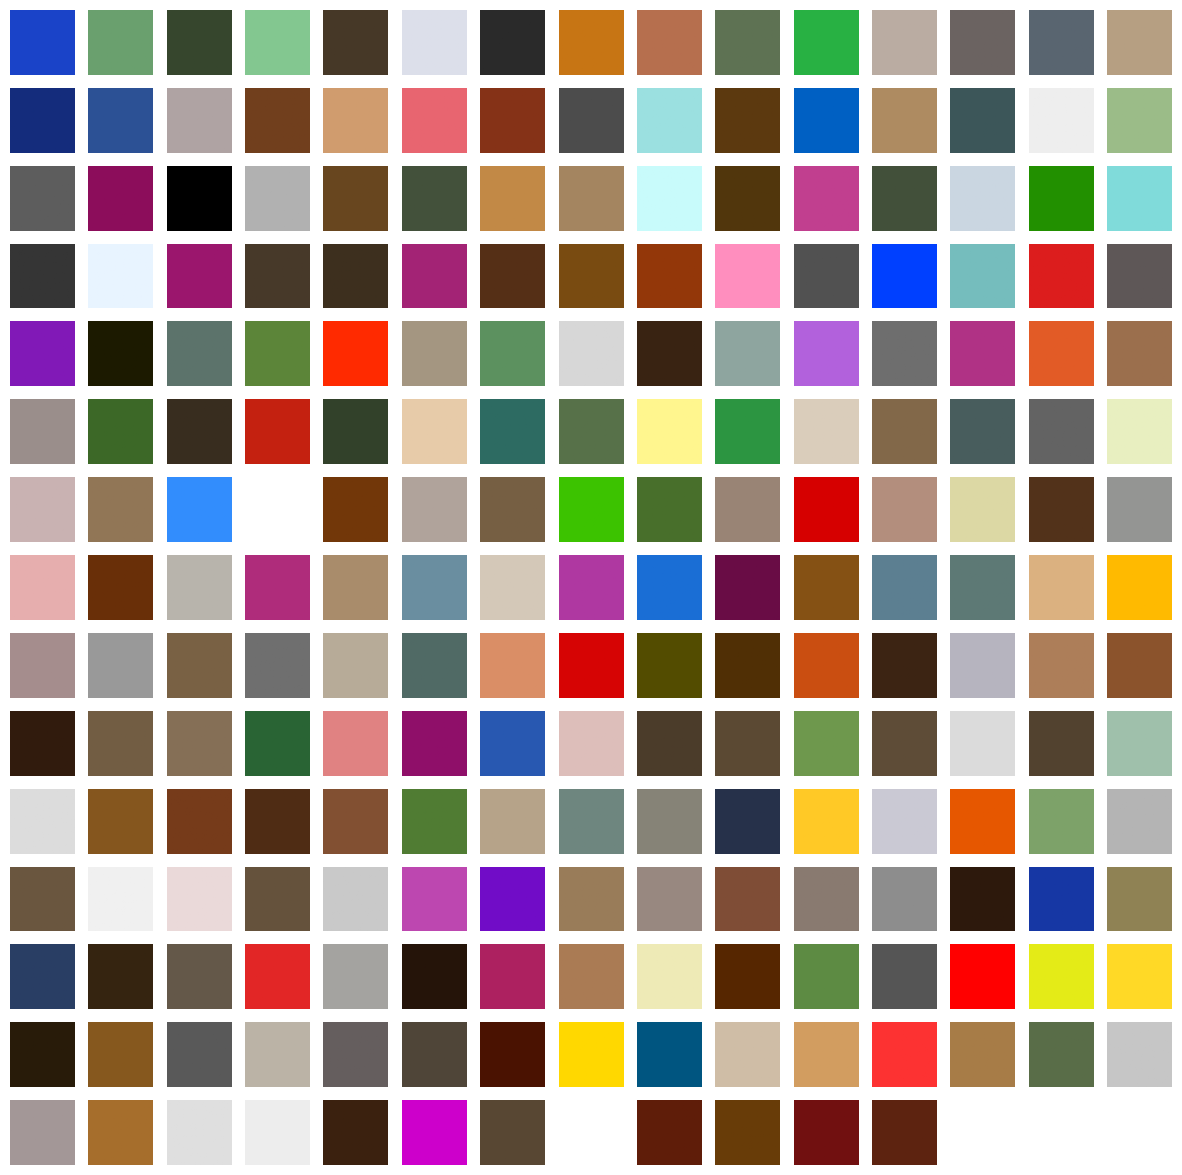

In [6]:
# Visualize every color

color_imgs = [np.full((24, 24, 4), c) for c in all_colors]
(x,y) = (15,15)
fig = plt.figure(figsize=(x,y))
i=1
for c in random.sample(color_imgs, 222):
    fig.add_subplot(x, y, i)
    plt.imshow(c)
    plt.axis('off')
    i=i+1


# Datasets

### RGBA Dataset

In [7]:
dataset = DS.CPunksDataset(test_size=2000)
train_sampler = SubsetRandomSampler(dataset.train_idx)
test_sampler = SubsetRandomSampler(dataset.test_idx)

print(f"\ndataset size:   {len(dataset)}")
print(f"  - train size: {len(dataset.train_idx)}")
print(f"  - test size:  {len(dataset.test_idx)}\n")
print(f"train sampler:  {len(train_sampler)}")
print(f"  - sample id:  {next(iter(train_sampler))}\n")
print(f"test sampler:   {len(test_sampler)}")
print(f"  - sample id:  {next(iter(test_sampler))}\n")


INFO | loading punk images
INFO | - image 0
INFO | - image 1000
INFO | - image 2000
INFO | - image 3000
INFO | - image 4000
INFO | - image 5000
INFO | - image 6000
INFO | - image 7000
INFO | - image 8000
INFO | - image 9000
INFO | punk images complete
INFO | loading punk labels: ../../cpunks-10k/cpunks/data/punks.json

dataset size:   10000
  - train size: 8000
  - test size:  2000

train sampler:  8000
  - sample id:  490

test sampler:   2000
  - sample id:  6557



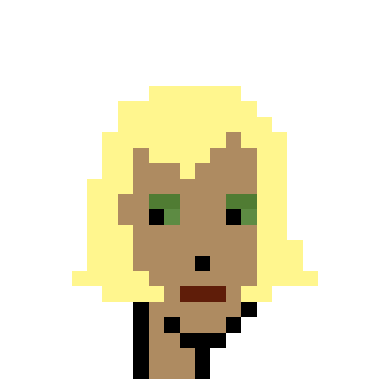

tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])


In [8]:
# Load punk from data loader and plot it

image, label = dataset[0]

plt.imshow(to_pil_image(image))
plt.axis('off')
plt.show()

print(label)

### One Hot Dataset

1. Instantiate a mapper to go from `all_colors` to its one-hot encoding.
2. Use mapper to encode & decode a whole punk image.
3. Create dataloader for punks that represents its color data as one hot vectors.
4. Load one-hot encoded punk from dataloader, decode it, plot it.

In [9]:
# Instantiate a mapper to go from `all_colors` to its one-hot encoding.

mapper = DS.ColorOneHotMapper(all_colors)

# Start with a test color
test_color = all_colors[2]
print(f"color:\n{test_color}\n")

# Convert test color to one hot
test_one_hot = mapper.to_one_hot(test_color)
print(f"one-hot encoded:\n{test_one_hot}\n")

# Convert one hot back to test color
retrieved_color = mapper.to_color(test_one_hot)
print(f"back as color:\n{retrieved_color}")


color:
tensor([0.0000, 0.2510, 1.0000, 1.0000])

one-hot encoded:
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

one hot encoded: torch.Size([222, 24, 24])
rgba encoded:    torch.Size([4, 24, 24])


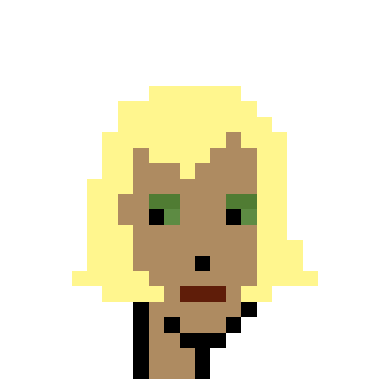

In [10]:
# Use mapper to encode & decode a whole punk image.

one_hot_encoded_image = DS.rgba_to_one_hot(image, mapper)
print(f"one hot encoded: {one_hot_encoded_image.shape}")

restored = DS.one_hot_to_rgba(one_hot_encoded_image, mapper)
print(f"rgba encoded:    {restored.shape}")

# Show an image after going to one hot encoding and back
plt.imshow(to_pil_image(restored))
plt.axis('off')
plt.show()


In [11]:
# Create dataloader for punks that represents its color data as one hot vectors.

dataset = DS.OneHotCPunksDataset(mapper, test_size=2000)
train_sampler = SubsetRandomSampler(dataset.train_idx)
test_sampler = SubsetRandomSampler(dataset.test_idx)

print(f"dataset size:   {len(dataset)}")
print(f"  - train size: {len(dataset.train_idx)}")
print(f"  - test size:  {len(dataset.test_idx)}\n")
print(f"train sampler:  {len(train_sampler)}")
print(f"  - sample id:  {next(iter(train_sampler))}\n")
print(f"test sampler:   {len(test_sampler)}")
print(f"  - sample id:  {next(iter(test_sampler))}\n")


INFO | loading punk images
INFO | - image 0
INFO | - image 1000
INFO | - image 2000
INFO | - image 3000
INFO | - image 4000
INFO | - image 5000
INFO | - image 6000
INFO | - image 7000
INFO | - image 8000
INFO | - image 9000
INFO | punk images complete
INFO | loading punk labels: ../../cpunks-10k/cpunks/data/punks.json
dataset size:   10000
  - train size: 8000
  - test size:  2000

train sampler:  8000
  - sample id:  4016

test sampler:   2000
  - sample id:  767



rgba encoded:    torch.Size([4, 24, 24])


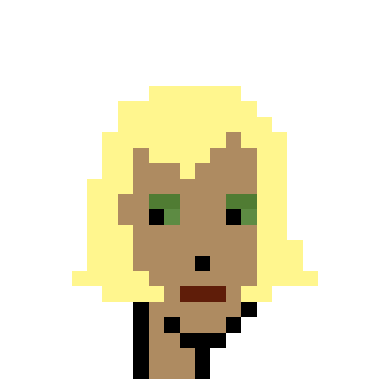

tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])


In [12]:
# Load one-hot encoded punk from dataloader, decode it, plot it.

one_hot_encoded_image, label = dataset[0]

restored = DS.one_hot_to_rgba(one_hot_encoded_image, mapper)
print(f"rgba encoded:    {restored.shape}")

plt.imshow(to_pil_image(restored))
plt.axis('off')
plt.show()

print(label)